## Import modules and mount drive

In [1]:
import pickle
import os
from typing import List, Tuple, Dict, Optional, Set
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from icecream import ic
import pandas as pd
import random
from tqdm import tqdm
import numpy as np
from numpy import atleast_1d
from datetime import datetime
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import torch.multiprocessing as mp
import pytorch_lightning as pl
import wandb

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define token alphabet

In [2]:
tokens = [
            "<cls>",
            "<pad>",
            "<eos>",
            "<unk>",
            ".",
            "-",
            "<null_1>",
            "<mask>",
            "L",
            "A",
            "G",
            "V",
            "S",
            "E",
            "R",
            "T",
            "I",
            "D",
            "P",
            "K",
            "Q",
            "N",
            "F",
            "Y",
            "M",
            "H",
            "W",
            "C",
            "X",
            "B",
            "U",
            "Z",
            "O",
            "PTM",
            "<N-linked (GlcNAc...) asparagine>",
            "<Pyrrolidone carboxylic acid>",
            "<Phosphoserine>",
            "<Phosphothreonine>",
            "<N-acetylalanine>",
            "<N-acetylmethionine>",
            "<N6-acetyllysine>",
            "<Phosphotyrosine>",
            "<S-diacylglycerol cysteine>",
            "<N6-(pyridoxal phosphate)lysine>",
            "<N-acetylserine>",
            "<N6-carboxylysine>",
            "<N6-succinyllysine>",
            "<S-palmitoyl cysteine>",
            "<O-(pantetheine 4'-phosphoryl)serine>",
            "<Sulfotyrosine>",
            "<O-linked (GalNAc...) threonine>",
            "<Omega-N-methylarginine>",
            "<N-myristoyl glycine>",
            "<4-hydroxyproline>",
            "<Asymmetric dimethylarginine>",
            "<N5-methylglutamine>",
            "<4-aspartylphosphate>",
            "<S-geranylgeranyl cysteine>",
            "<4-carboxyglutamate>",
        ]
token_to_index = {token: i for i, token in enumerate(tokens)}
token_to_index = {token: i for i, token in enumerate(tokens)}

## Load dataset

In [3]:
seqs_df = pd.read_csv('/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/data/seqs_df.csv')

seqs_df.head()

,uniprot_id,accession_id,wt_seq,ptm_seq,one_hot_embedding_path,one_hot_ptm_embedding_path,esm_650m_embedding_path,esm_3b_embedding_path,ptm_mamba_embedding_path,is_druggable,is_disease,is_part_of_druggability_dataset,is_part_of_disease_dataset,is_train
0,P07107,P07107,MSQAEFDKAAEEVKHLKTKPADEEMLFIYSHYKQATVGDINTERPG...,M<N-acetylserine>QAEFDKAAEEVKHL<N6-succinyllys...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,True,False,True,False,True
1,O00590,O00590,MAATASPQPLATEDADSENSSFYYYDYLDEVAFMLCRKDAVVSFGK...,MAATASPQPLATEDADSE<N-linked (GlcNAc...) aspara...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,False,True,False,True,True
2,O75716,O75716,MGHALCVCSRGTVIIDNKRYLFIQKLGEGGFSYVDLVEGLHDGHFY...,MGHALCVCSRGTVIIDNKRYLFIQKLGEGGFSYVDLVEGLHDGHFY...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,True,False,True,False,True
3,P23560,Q5IS78,MTILFLTMVISYFGCMKAAPMKEANIRGQGGLAYPGVRTHGTLESV...,MTILFLTMVISYFGCMKAAPMKEANIRGQGGLAYPGVRTHGTLESV...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,False,True,False,True,True
4,Q99471,Q99471,MAQSINITELNLPQLEMLKNQLDQEVEFLSTSIAQLKVVQTKYVEA...,M<N-acetylalanine>QSINITELNLPQLEMLKNQLDQEVEFLS...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,/workspace/protein_lm/evaluation/nonptm_vs_ptm...,False,False,True,False,True


## Create dataset class

In [4]:
class ProteinDataset(Dataset):
  def __init__(self, df, device, label_column, embedding_column):
    self.df = df
    self.device = device
    self.label_column = label_column
    self.embedding_column = embedding_column

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    uniprot_id = row['uniprot_id']
    label = row[self.label_column]
    label = int(label)
    embedding_path = row[self.embedding_column]
    embedding = torch.load(embedding_path)
    return uniprot_id, label, embedding.to(self.device)

## Create data loaders

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
drugptm_train_df = seqs_df[(seqs_df['is_part_of_druggability_dataset'] == True) & (seqs_df['is_train'] == True)]
drugptm_test_df = seqs_df[(seqs_df['is_part_of_druggability_dataset'] == True) & (seqs_df['is_train'] == False)]

disease_train_df = seqs_df[(seqs_df['is_part_of_disease_dataset'] == True) & (seqs_df['is_train'] == True)]
disease_test_df = seqs_df[(seqs_df['is_part_of_disease_dataset'] == True) & (seqs_df['is_train'] == False)]

In [7]:
drugptm_train_dataset = ProteinDataset(drugptm_train_df,
                                    device,
                                    'is_druggable',
                                    'ptm_mamba_embedding_path')

In [8]:
drugptm_esm650_train_dataset = ProteinDataset(drugptm_train_df, device, 'is_druggable', 'esm_650m_embedding_path')
drugptm_esm650_test_dataset = ProteinDataset(drugptm_test_df, device, 'is_druggable', 'esm_650m_embedding_path')

drugptm_esm3b_train_dataset = ProteinDataset(drugptm_train_df, device, 'is_druggable', 'esm_3b_embedding_path')
drugptm_esm3b_test_dataset = ProteinDataset(drugptm_test_df, device, 'is_druggable', 'esm_3b_embedding_path')

drugptm_onehot_train_dataset = ProteinDataset(drugptm_train_df, device, 'is_druggable', 'one_hot_embedding_path')
drugptm_onehot_test_dataset = ProteinDataset(drugptm_test_df, device, 'is_druggable', 'one_hot_embedding_path')

drugptm_onehotptm_train_dataset = ProteinDataset(drugptm_train_df, device, 'is_druggable', 'one_hot_ptm_embedding_path')
drugptm_onehotptm_test_dataset = ProteinDataset(drugptm_test_df, device, 'is_druggable', 'one_hot_ptm_embedding_path')

drugptm_ptmmamba_train_dataset = ProteinDataset(drugptm_train_df, device, 'is_druggable', 'ptm_mamba_embedding_path')
drugptm_ptmmamba_test_dataset = ProteinDataset(drugptm_test_df, device, 'is_druggable', 'ptm_mamba_embedding_path')

disease_esm650_train_dataset = ProteinDataset(disease_train_df, device, 'is_disease', 'esm_650m_embedding_path')
disease_esm650_test_dataset = ProteinDataset(disease_test_df,  device,  'is_disease', 'esm_650m_embedding_path')

disease_esm3b_train_dataset = ProteinDataset(disease_train_df, device, 'is_disease', 'esm_3b_embedding_path')
disease_esm3b_test_dataset = ProteinDataset(disease_test_df, device, 'is_disease', 'esm_3b_embedding_path')

disease_onehot_train_dataset = ProteinDataset(disease_train_df, device, 'is_disease', 'one_hot_embedding_path')
disease_onehot_test_dataset = ProteinDataset(disease_test_df, device, 'is_disease', 'one_hot_embedding_path')

disease_onehotptm_train_dataset = ProteinDataset(disease_train_df, device, 'is_disease', 'one_hot_ptm_embedding_path')
disease_onehotptm_test_dataset = ProteinDataset(disease_test_df, device, 'is_disease', 'one_hot_ptm_embedding_path')

disease_ptmmamba_train_dataset = ProteinDataset(disease_train_df, device, 'is_disease', 'ptm_mamba_embedding_path')
disease_ptmmamba_test_dataset = ProteinDataset(disease_test_df, device, 'is_disease', 'ptm_mamba_embedding_path')

In [9]:
batch_size = 256
num_workers = 0

drugptm_esm650_train_dataloader = DataLoader(drugptm_esm650_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
drugptm_esm650_test_dataloader = DataLoader(drugptm_esm650_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

drugptm_esm3b_train_dataloader = DataLoader(drugptm_esm3b_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
drugptm_esm3b_test_dataloader = DataLoader(drugptm_esm3b_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

drugptm_onehot_train_dataloader = DataLoader(drugptm_onehot_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
drugptm_onehot_test_dataloader = DataLoader(drugptm_onehot_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

drugptm_onehotptm_train_dataloader = DataLoader(drugptm_onehotptm_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
drugptm_onehotptm_test_dataloader = DataLoader(drugptm_onehotptm_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

drugptm_ptmmamba_train_dataloader = DataLoader(drugptm_ptmmamba_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
drugptm_ptmmamba_test_dataloader = DataLoader(drugptm_ptmmamba_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

disease_esm650_train_dataloader = DataLoader(disease_esm650_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
disease_esm650_test_dataloader = DataLoader(disease_esm650_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

disease_esm3b_train_dataloader = DataLoader(disease_esm3b_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
disease_esm3b_test_dataloader = DataLoader(disease_esm3b_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

disease_onehot_train_dataloader = DataLoader(disease_onehot_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
disease_onehot_test_dataloader = DataLoader(disease_onehot_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

disease_onehotptm_train_dataloader = DataLoader(disease_onehotptm_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
disease_onehotptm_test_dataloader = DataLoader(disease_onehotptm_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

disease_ptmmamba_train_dataloader = DataLoader(disease_ptmmamba_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
disease_ptmmamba_test_dataloader = DataLoader(disease_ptmmamba_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [10]:
ic(len(drugptm_esm650_train_dataset))
ic(len(drugptm_esm650_test_dataset))
ic(len(disease_esm650_train_dataset))
ic(len(disease_esm650_test_dataset))

ic| len(drugptm_esm650_train_dataset): 557
ic| len(drugptm_esm650_test_dataset): 139
ic| len(disease_esm650_train_dataset): 817
ic| len(disease_esm650_test_dataset): 213


213

## Create classification models

In [11]:
class MLP(pl.LightningModule):
  def __init__(self, input_size, lr=1e-3):
    super(MLP, self).__init__()
    self.lr = lr
    self.flatten = nn.Flatten()
    self.mlp = nn.Sequential(
      nn.Linear(input_size, 2)
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.mlp(x)
    return x

  def training_step(self, batch, batch_idx):
    protein_ids, labels, embeddings = batch
    outputs = self(embeddings)
    loss = F.cross_entropy(outputs, labels)
    self.log('train_loss', loss, prog_bar=True)
    return loss
  
  def validation_step(self, batch, batch_idx):
    protein_ids, labels, embeddings = batch
    outputs = self(embeddings)
    loss = F.cross_entropy(outputs, labels)
    accuracy = accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())
    self.log('val_loss', loss, prog_bar=True)
    self.log('val_accuracy', accuracy, prog_bar=True)
    return {'val_loss': loss, 'labels': labels, 'outputs': outputs}

  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr=self.lr)

In [12]:
class EmbeddingMLP(pl.LightningModule):
	def __init__(self, vocab_size, embedding_dim, lr=1e-3):
		super(EmbeddingMLP, self).__init__()
		self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
		self.fc = nn.Sequential(
			nn.Linear(embedding_dim, 2)
		)
		self.lr = lr

	def forward(self, x):
		x = x.to(torch.int32)
		embedded = self.embedding(x)
		embedded = embedded.mean(dim=1)
		linear_output = self.fc(embedded)
		softmax_output = F.log_softmax(linear_output, dim=1)
		return softmax_output

	def training_step(self, batch, batch_idx):
		protein_ids, labels, embeddings = batch
		outputs = self(embeddings)
		loss = F.cross_entropy(outputs, labels)
		self.log('train_loss', loss, prog_bar=True)
		return loss

	def validation_step(self, batch, batch_idx):
		protein_ids, labels, embeddings = batch
		outputs = self(embeddings)
		loss = F.cross_entropy(outputs, labels)
		accuracy = accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())
		f1 = f1_score(labels.cpu(), outputs.argmax(dim=1).cpu())
		self.log('val_loss', loss, prog_bar=True)
		self.log('val_accuracy', accuracy, prog_bar=True)
		self.log('val_f1', f1, prog_bar=True)
		return {'val_loss': loss, 'labels': labels, 'outputs': outputs}

	def configure_optimizers(self):
		return optim.Adam(self.parameters(), lr=self.lr)

## Define evaluation function

In [13]:
def evaluate_classification_model(model, test_loader, title, device):
    model.to(device)
    model.eval()

    y_pred = []
    y_true = []
    y_scores = []  # Collecting probability scores for the positive class

    with torch.no_grad():
        for protein_ids, labels, embeddings in test_loader:
            outputs = model(embeddings)
            predicted_classes = torch.argmax(outputs, dim=1)
            y_pred.extend(predicted_classes.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    mcc = matthews_corrcoef(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
    auprc = average_precision_score(y_true, y_scores)

    # plt.figure()
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(title)
    # plt.legend(loc="lower right")
    # plt.show()

    # print(f'Accuracy: {accuracy:.4f}')
    # print(f'Precision: {precision:.4f}')
    # print(f'Recall: {recall:.4f}')
    # print(f'F1 Score: {f1:.4f}')
    # print(f'MCC: {mcc:.4f}')
    # print(f'AUROC: {roc_auc:.4f}')
    # print(f'AUPRC: {auprc:.4f}')

    model.cpu()
    date_time = datetime.now().strftime("%Y%m%d-%H%M%S")
    model_path = f'/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/{title}__{roc_auc}.pt'
    torch.save(model.state_dict(), model_path)
    print(f'Model saved to {model_path}')

    accuracy_metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'auroc': roc_auc,
        'auprc': auprc
    }

    return accuracy_metrics_dict

## Define training function

In [14]:
vocab_size = len(tokens)
esm650_embedding_dimension = 1280
esm3b_embedding_dimension = 2560
onehotptm_embedding_dimension = 1280
onehot_embedding_dimension = 1280
ptmmamba_embedding_dimension = 768
lr = 0.0008

drugptm_esm650_model = MLP(esm650_embedding_dimension, lr)
drugptm_esm3b_model = MLP(esm3b_embedding_dimension, lr)
drugptm_onehotptm_model = EmbeddingMLP(vocab_size, onehotptm_embedding_dimension, lr)
drugptm_onehot_model = EmbeddingMLP(vocab_size, onehot_embedding_dimension, lr)
drugptm_ptmmamba_model = MLP(ptmmamba_embedding_dimension, lr)

disease_esm650_model = MLP(esm650_embedding_dimension, lr)
disease_esm3b_model = MLP(esm3b_embedding_dimension, lr)
disease_onehotptm_model = EmbeddingMLP(vocab_size, onehotptm_embedding_dimension, lr)
disease_onehot_model = EmbeddingMLP(vocab_size, onehot_embedding_dimension, lr)
disease_ptmmamba_model = MLP(ptmmamba_embedding_dimension, lr)

In [15]:
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping

def train_classification_model(model_class, is_onehot_model, input_size, vocab_size, embedding_dim, train_loader, test_loader, num_epochs, num_iterations, model_name):
  metrics_list = []
  for i in range(num_iterations):
    seed_everything(int(i))
    if is_onehot_model:
      model = model_class(vocab_size, embedding_dim)
    else:
      model = model_class(input_size)
    now = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
    run_name = f'{model_name}__{now}__iteration_{i}'
    # wandb.init(project=model_name, name=run_name, id=run_name)
    # wandb_logger = pl.loggers.WandbLogger(project='drugptm_snpptm',log_model=True)
    early_stop_callback = EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=True,
            mode='min'
        )
    trainer = pl.Trainer(max_epochs=num_epochs,)# callbacks=[early_stop_callback])
    
    trainer.fit(model, train_loader, test_loader)
    metrics = evaluate_classification_model(model, test_loader, run_name, device)
    metrics_list.append(metrics)
  
  averaged_metrics = {}
  for metric in metrics_list[0].keys():
    metric_values = [m[metric] for m in metrics_list]
    metric_values.remove(min(metric_values))
    metric_values.remove(min(metric_values))
    metric_values.remove(max(metric_values))
    metric_values.remove(max(metric_values))
    averaged_metrics[metric] = np.mean(metric_values)
  return averaged_metrics, metrics_list

## Train and evaluate models

In [16]:
num_iterations = 5
num_epochs = 40

In [17]:
# esm_650m_drugptm

esm_650m_drugptm_averaged_metrics, _ = train_classification_model(MLP,
							False,
							esm650_embedding_dimension, 
							0,
							0,
							drugptm_esm650_train_dataloader, drugptm_esm650_test_dataloader,
							num_epochs-15,
							num_iterations,
							'drugptm_esm650_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.56it/s, v_num=1329, train_loss=0.366, val_loss=0.360, val_accuracy=0.842]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.41it/s, v_num=1329, train_loss=0.366, val_loss=0.360, val_accuracy=0.842]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm650_model__2024-02-25_04_55_54__iteration_0__0.9191004672897197.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.61it/s, v_num=1330, train_loss=0.392, val_loss=0.349, val_accuracy=0.849]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.46it/s, v_num=1330, train_loss=0.392, val_loss=0.349, val_accuracy=0.849]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm650_model__2024-02-25_04_56_03__iteration_1__0.9173481308411215.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.66it/s, v_num=1331, train_loss=0.391, val_loss=0.362, val_accuracy=0.856]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s, v_num=1331, train_loss=0.391, val_loss=0.362, val_accuracy=0.856]


Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm650_model__2024-02-25_04_56_09__iteration_2__0.9170560747663551.pt



  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.41it/s, v_num=1332, train_loss=0.196, val_loss=0.350, val_accuracy=0.856]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.26it/s, v_num=1332, train_loss=0.196, val_loss=0.350, val_accuracy=0.856]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm650_model__2024-02-25_04_56_16__iteration_3__0.9167640186915887.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.51it/s, v_num=1333, train_loss=0.376, val_loss=0.354, val_accuracy=0.849]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 3/3 [00:00<00:00, 11.36it/s, v_num=1333, train_loss=0.376, val_loss=0.354, val_accuracy=0.849]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm650_model__2024-02-25_04_56_23__iteration_4__0.9164719626168224.pt


In [18]:
# esm_650m_disease

esm_650m_disease_averaged_metrics, _ = train_classification_model(MLP,
							False,
							esm650_embedding_dimension, 
							0,
							0,
							disease_esm650_train_dataloader, disease_esm650_test_dataloader,
							num_epochs,
							num_iterations,
							'disease_esm650_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.50it/s, v_num=1334, train_loss=0.635, val_loss=0.594, val_accuracy=0.662]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.40it/s, v_num=1334, train_loss=0.635, val_loss=0.594, val_accuracy=0.662]

Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm650_model__2024-02-25_04_56_30__iteration_0__0.7365355233002292.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.72it/s, v_num=1335, train_loss=0.538, val_loss=0.590, val_accuracy=0.662]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.62it/s, v_num=1335, train_loss=0.538, val_loss=0.590, val_accuracy=0.662]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm650_model__2024-02-25_04_56_45__iteration_1__0.7332887700534759.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.72it/s, v_num=1336, train_loss=0.625, val_loss=0.585, val_accuracy=0.685]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.62it/s, v_num=1336, train_loss=0.625, val_loss=0.585, val_accuracy=0.685]


Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm650_model__2024-02-25_04_57_01__iteration_2__0.7394003055767762.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.71it/s, v_num=1337, train_loss=0.543, val_loss=0.588, val_accuracy=0.653]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.61it/s, v_num=1337, train_loss=0.543, val_loss=0.588, val_accuracy=0.653]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm650_model__2024-02-25_04_57_16__iteration_3__0.7361535523300229.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.62it/s, v_num=1338, train_loss=0.563, val_loss=0.587, val_accuracy=0.662]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.53it/s, v_num=1338, train_loss=0.563, val_loss=0.587, val_accuracy=0.662]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm650_model__2024-02-25_04_57_31__iteration_4__0.7479946524064172.pt


In [19]:
# esm_3b_drugptm

esm_3b_drugptm_averaged_metrics, _ = train_classification_model(MLP,
							False,
							esm3b_embedding_dimension, 
							0,
							0,
							drugptm_esm3b_train_dataloader, drugptm_esm3b_test_dataloader,
							num_epochs-20,
							num_iterations,
							'drugptm_esm3b_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.41it/s, v_num=1339, train_loss=0.0203, val_loss=0.567, val_accuracy=0.856] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.27it/s, v_num=1339, train_loss=0.0203, val_loss=0.567, val_accuracy=0.856]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm3b_model__2024-02-25_04_57_47__iteration_0__0.8945677570093458.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.30it/s, v_num=1340, train_loss=0.00795, val_loss=0.545, val_accuracy=0.856]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.15it/s, v_num=1340, train_loss=0.00795, val_loss=0.545, val_accuracy=0.856]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm3b_model__2024-02-25_04_57_53__iteration_1__0.8986565420560748.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.35it/s, v_num=1341, train_loss=0.0296, val_loss=0.498, val_accuracy=0.856]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.21it/s, v_num=1341, train_loss=0.0296, val_loss=0.498, val_accuracy=0.856]


Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm3b_model__2024-02-25_04_57_58__iteration_2__0.8487149532710281.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.38it/s, v_num=1342, train_loss=0.0541, val_loss=0.505, val_accuracy=0.885]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.24it/s, v_num=1342, train_loss=0.0541, val_loss=0.505, val_accuracy=0.885]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm3b_model__2024-02-25_04_58_04__iteration_3__0.8767523364485982.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.36it/s, v_num=1343, train_loss=0.0134, val_loss=0.680, val_accuracy=0.885] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 11.22it/s, v_num=1343, train_loss=0.0134, val_loss=0.680, val_accuracy=0.885]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_esm3b_model__2024-02-25_04_58_09__iteration_4__0.8656542056074765.pt


In [20]:
esm_3b_drugptm_averaged_metrics

{'accuracy': 0.8561151079136691,
 'precision': 0.9026548672566371,
 'recall': 0.9439252336448598,
 'f1': 0.9115044247787611,
 'mcc': 0.623156124512257,
 'auroc': 0.8767523364485982,
 'auprc': 0.9513815250350997}

In [21]:
# esm_3b_disease

esm_3b_disease_averaged_metrics, _ = train_classification_model(MLP,
							False,
							esm3b_embedding_dimension, 
							0,
							0,
							disease_esm3b_train_dataloader, disease_esm3b_test_dataloader,
							num_epochs,
							num_iterations,
							'disease_esm3b_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.33it/s, v_num=1344, train_loss=0.376, val_loss=1.470, val_accuracy=0.634]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.23it/s, v_num=1344, train_loss=0.376, val_loss=1.470, val_accuracy=0.634]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm3b_model__2024-02-25_04_58_15__iteration_0__0.5631207028265852.pt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.44it/s, v_num=1345, train_loss=0.168, val_loss=1.470, val_accuracy=0.610] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.34it/s, v_num=1345, train_loss=0.168, val_loss=1.470, val_accuracy=0.610]

Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm3b_model__2024-02-25_04_58_31__iteration_1__0.5120320855614974.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.48it/s, v_num=1346, train_loss=0.139, val_loss=1.390, val_accuracy=0.643]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.39it/s, v_num=1346, train_loss=0.139, val_loss=1.390, val_accuracy=0.643]

Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm3b_model__2024-02-25_04_58_46__iteration_2__0.5469824293353706.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.49it/s, v_num=1347, train_loss=0.151, val_loss=1.470, val_accuracy=0.596]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.39it/s, v_num=1347, train_loss=0.151, val_loss=1.470, val_accuracy=0.596]

Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.



Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm3b_model__2024-02-25_04_59_02__iteration_3__0.4922650878533231.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 5.1 K 
---------------------------------------
5.1 K     Trainable params
0         Non-trainable params
5.1 K     Total params
0.020     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.32it/s, v_num=1348, train_loss=0.128, val_loss=1.390, val_accuracy=0.592]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.23it/s, v_num=1348, train_loss=0.128, val_loss=1.390, val_accuracy=0.592]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_esm3b_model__2024-02-25_04_59_18__iteration_4__0.6013177998472116.pt


In [22]:
# onehotptm_drugptm

onehotptm_drugptm_averaged_metrics, _ = train_classification_model(EmbeddingMLP,
							True,
							0, 
							vocab_size,
							onehotptm_embedding_dimension,
							drugptm_onehotptm_train_dataloader, drugptm_onehotptm_test_dataloader,
							num_epochs,
							num_iterations,
							'drugptm_onehotptm_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s, v_num=1349, train_loss=0.622, val_loss=0.558, val_accuracy=0.791, val_f1=0.878]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.76it/s, v_num=1349, train_loss=0.622, val_loss=0.558, val_accuracy=0.791, val_f1=0.878]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehotptm_model__2024-02-25_04_59_34__iteration_0__0.6875.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s, v_num=1350, train_loss=0.629, val_loss=0.518, val_accuracy=0.755, val_f1=0.861]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s, v_num=1350, train_loss=0.629, val_loss=0.518, val_accuracy=0.755, val_f1=0.861]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehotptm_model__2024-02-25_04_59_52__iteration_1__0.6837032710280373.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, v_num=1351, train_loss=0.580, val_loss=0.531, val_accuracy=0.784, val_f1=0.874]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, v_num=1351, train_loss=0.580, val_loss=0.531, val_accuracy=0.784, val_f1=0.874]


Seed set to 3


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehotptm_model__2024-02-25_05_00_10__iteration_2__0.6889602803738317.pt


Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.88it/s, v_num=1352, train_loss=0.524, val_loss=0.519, val_accuracy=0.755, val_f1=0.861]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.80it/s, v_num=1352, train_loss=0.524, val_loss=0.519, val_accuracy=0.755, val_f1=0.861]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehotptm_model__2024-02-25_05_00_28__iteration_3__0.6872079439252337.pt

Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.85it/s, v_num=1353, train_loss=0.600, val_loss=0.520, val_accuracy=0.763, val_f1=0.863]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.76it/s, v_num=1353, train_loss=0.600, val_loss=0.520, val_accuracy=0.763, val_f1=0.863]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehotptm_model__2024-02-25_05_00_46__iteration_4__0.6866238317757009.pt


In [23]:
# onehotptm_disease

onehotptm_disease_averaged_metrics, _ = train_classification_model(EmbeddingMLP,
							True,
							0, 
							vocab_size,
							onehotptm_embedding_dimension,
							disease_onehotptm_train_dataloader, disease_onehotptm_test_dataloader,
							num_epochs,
							num_iterations,
							'disease_onehotptm_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, v_num=1354, train_loss=0.621, val_loss=0.593, val_accuracy=0.676, val_f1=0.793]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, v_num=1354, train_loss=0.621, val_loss=0.593, val_accuracy=0.676, val_f1=0.793]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehotptm_model__2024-02-25_05_01_04__iteration_0__0.7220206264323911.pt
                                                                           

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s, v_num=1355, train_loss=0.667, val_loss=0.595, val_accuracy=0.653, val_f1=0.786]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, v_num=1355, train_loss=0.667, val_loss=0.595, val_accuracy=0.653, val_f1=0.786]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehotptm_model__2024-02-25_05_01_30__iteration_1__0.7222116119174944.pt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, v_num=1356, train_loss=0.561, val_loss=0.596, val_accuracy=0.638, val_f1=0.779]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, v_num=1356, train_loss=0.561, val_loss=0.596, val_accuracy=0.638, val_f1=0.779]


Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehotptm_model__2024-02-25_05_01_57__iteration_2__0.7248854087089381.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 26.30it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, v_num=1357, train_loss=0.674, val_loss=0.604, val_accuracy=0.638, val_f1=0.779]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, v_num=1357, train_loss=0.674, val_loss=0.604, val_accuracy=0.638, val_f1=0.779]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehotptm_model__2024-02-25_05_02_23__iteration_3__0.722498090145149.pt
                                                                           

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, v_num=1358, train_loss=0.726, val_loss=0.599, val_accuracy=0.690, val_f1=0.794]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, v_num=1358, train_loss=0.726, val_loss=0.599, val_accuracy=0.690, val_f1=0.794]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehotptm_model__2024-02-25_05_02_49__iteration_4__0.7222116119174943.pt


In [24]:
# onehot_drugptm

onehot_drugptm_averaged_metrics, _ = train_classification_model(EmbeddingMLP,
							True,
							0, 
							vocab_size,
							onehot_embedding_dimension,
							drugptm_onehot_train_dataloader, drugptm_onehot_test_dataloader,
							num_epochs,
							num_iterations,
							'drugptm_onehot_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, v_num=1359, train_loss=0.622, val_loss=0.558, val_accuracy=0.791, val_f1=0.878]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, v_num=1359, train_loss=0.622, val_loss=0.558, val_accuracy=0.791, val_f1=0.878]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehot_model__2024-02-25_05_03_15__iteration_0__0.686623831775701.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.86it/s, v_num=1360, train_loss=0.629, val_loss=0.518, val_accuracy=0.755, val_f1=0.861]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.77it/s, v_num=1360, train_loss=0.629, val_loss=0.518, val_accuracy=0.755, val_f1=0.861]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehot_model__2024-02-25_05_03_33__iteration_1__0.6837032710280373.pt


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, v_num=1361, train_loss=0.579, val_loss=0.531, val_accuracy=0.784, val_f1=0.874]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, v_num=1361, train_loss=0.579, val_loss=0.531, val_accuracy=0.784, val_f1=0.874]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehot_model__2024-02-25_05_03_51__iteration_2__0.6886682242990654.pt

Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.87it/s, v_num=1362, train_loss=0.524, val_loss=0.519, val_accuracy=0.755, val_f1=0.861]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.78it/s, v_num=1362, train_loss=0.524, val_loss=0.519, val_accuracy=0.755, val_f1=0.861]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehot_model__2024-02-25_05_04_09__iteration_3__0.6857476635514017.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.83it/s, v_num=1363, train_loss=0.600, val_loss=0.521, val_accuracy=0.763, val_f1=0.863]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 3/3 [00:00<00:00,  6.75it/s, v_num=1363, train_loss=0.600, val_loss=0.521, val_accuracy=0.763, val_f1=0.863]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_onehot_model__2024-02-25_05_04_27__iteration_4__0.6851635514018691.pt


In [25]:
# onehot_disease

onehot_disease_averaged_metrics, _ = train_classification_model(EmbeddingMLP,
							True,
							0, 
							vocab_size,
							onehot_embedding_dimension,
							disease_onehot_train_dataloader, disease_onehot_test_dataloader,
							num_epochs,
							num_iterations,
							'disease_onehot_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, v_num=1364, train_loss=0.620, val_loss=0.593, val_accuracy=0.681, val_f1=0.795]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s, v_num=1364, train_loss=0.620, val_loss=0.593, val_accuracy=0.681, val_f1=0.795]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehot_model__2024-02-25_05_04_45__iteration_0__0.7212566844919786.pt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, v_num=1365, train_loss=0.667, val_loss=0.594, val_accuracy=0.653, val_f1=0.786]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s, v_num=1365, train_loss=0.667, val_loss=0.594, val_accuracy=0.653, val_f1=0.786]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehot_model__2024-02-25_05_05_11__iteration_1__0.7222116119174943.pt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, v_num=1366, train_loss=0.561, val_loss=0.596, val_accuracy=0.638, val_f1=0.779]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, v_num=1366, train_loss=0.561, val_loss=0.596, val_accuracy=0.638, val_f1=0.779]


Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehot_model__2024-02-25_05_05_37__iteration_2__0.7239304812834224.pt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, v_num=1367, train_loss=0.674, val_loss=0.603, val_accuracy=0.638, val_f1=0.779]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, v_num=1367, train_loss=0.674, val_loss=0.603, val_accuracy=0.638, val_f1=0.779]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehot_model__2024-02-25_05_06_03__iteration_3__0.7225935828877006.pt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 75.5 K
1 | fc        | Sequential | 2.6 K 
-----------------------------------------
78.1 K    Trainable params
0         Non-trainable params
78.1 K    Total params
0.312     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s, v_num=1368, train_loss=0.726, val_loss=0.599, val_accuracy=0.690, val_f1=0.794]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s, v_num=1368, train_loss=0.726, val_loss=0.599, val_accuracy=0.690, val_f1=0.794]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_onehot_model__2024-02-25_05_06_29__iteration_4__0.7218296409472881.pt


In [26]:
# ptmmamba_drugptm

ptmmamba_drugptm_averaged_metrics, _ = train_classification_model(MLP,
							False,
							ptmmamba_embedding_dimension, 
							0,
							0,
							drugptm_ptmmamba_train_dataloader, drugptm_ptmmamba_test_dataloader,
							num_epochs+10,
							num_iterations,
							'drugptm_ptmmamba_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.59it/s, v_num=1369, train_loss=0.369, val_loss=0.319, val_accuracy=0.849]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.44it/s, v_num=1369, train_loss=0.369, val_loss=0.319, val_accuracy=0.849]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_ptmmamba_model__2024-02-25_05_06_55__iteration_0__0.9024532710280374.pt



  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.62it/s, v_num=1370, train_loss=0.218, val_loss=0.308, val_accuracy=0.878]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.48it/s, v_num=1370, train_loss=0.218, val_loss=0.308, val_accuracy=0.878]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_ptmmamba_model__2024-02-25_05_07_08__iteration_1__0.9088785046728972.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.53it/s, v_num=1371, train_loss=0.187, val_loss=0.315, val_accuracy=0.849]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.38it/s, v_num=1371, train_loss=0.187, val_loss=0.315, val_accuracy=0.849]


Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_ptmmamba_model__2024-02-25_05_07_21__iteration_2__0.90946261682243.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.67it/s, v_num=1372, train_loss=0.348, val_loss=0.313, val_accuracy=0.856]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.53it/s, v_num=1372, train_loss=0.348, val_loss=0.313, val_accuracy=0.856]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_ptmmamba_model__2024-02-25_05_07_35__iteration_3__0.9100467289719626.pt
                                                                            

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.45it/s, v_num=1373, train_loss=0.327, val_loss=0.306, val_accuracy=0.878]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 3/3 [00:00<00:00, 11.30it/s, v_num=1373, train_loss=0.327, val_loss=0.306, val_accuracy=0.878]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/drugptm_ptmmamba_model__2024-02-25_05_07_48__iteration_4__0.9129672897196262.pt


In [27]:
# ptmmamba_disease

ptmmamba_disease_averaged_metrics, _ = train_classification_model(MLP,
							False,
							ptmmamba_embedding_dimension, 
							0,
							0,
							disease_ptmmamba_train_dataloader, disease_ptmmamba_test_dataloader,
							num_epochs,
							num_iterations,
							'disease_ptmmamba_model')

Seed set to 0
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.59it/s, v_num=1374, train_loss=0.623, val_loss=0.566, val_accuracy=0.700]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.49it/s, v_num=1374, train_loss=0.623, val_loss=0.566, val_accuracy=0.700]


Seed set to 1
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_ptmmamba_model__2024-02-25_05_08_01__iteration_0__0.7693850267379679.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.67it/s, v_num=1375, train_loss=0.639, val_loss=0.580, val_accuracy=0.667]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.58it/s, v_num=1375, train_loss=0.639, val_loss=0.580, val_accuracy=0.667]


Seed set to 2
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_ptmmamba_model__2024-02-25_05_08_17__iteration_1__0.7420741023682199.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.75it/s, v_num=1376, train_loss=0.529, val_loss=0.570, val_accuracy=0.695]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.66it/s, v_num=1376, train_loss=0.529, val_loss=0.570, val_accuracy=0.695]


Seed set to 3
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_ptmmamba_model__2024-02-25_05_08_32__iteration_2__0.7559205500381971.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.60it/s, v_num=1377, train_loss=0.575, val_loss=0.559, val_accuracy=0.681]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.51it/s, v_num=1377, train_loss=0.575, val_loss=0.559, val_accuracy=0.681]


Seed set to 4
Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_ptmmamba_model__2024-02-25_05_08_48__iteration_3__0.7608861726508787.pt


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type       | Params
---------------------------------------
0 | flatten | Flatten    | 0     
1 | mlp     | Sequential | 1.5 K 
---------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.66it/s, v_num=1378, train_loss=0.647, val_loss=0.573, val_accuracy=0.695]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 4/4 [00:00<00:00, 10.57it/s, v_num=1378, train_loss=0.647, val_loss=0.573, val_accuracy=0.695]
Model saved to /workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts/disease_ptmmamba_model__2024-02-25_05_09_03__iteration_4__0.7106569900687548.pt


## Generate tables

In [28]:
drugptm_model_names = [
	'drugptm_esm650_model',
	'drugptm_esm3b_model',
	'drugptm_onehotptm_model',
	'drugptm_onehot_model',
	'drugptm_ptmmamba_model'
]

disease_model_names = [
	'disease_esm650_model',
	'disease_esm3b_model',
	'disease_onehotptm_model',
	'disease_onehot_model',
	'disease_ptmmamba_model'
]

drugptm_metrics = [
	esm_650m_drugptm_averaged_metrics,
	esm_3b_drugptm_averaged_metrics,
	onehotptm_drugptm_averaged_metrics,
	onehot_drugptm_averaged_metrics,
	ptmmamba_drugptm_averaged_metrics
]

disease_metrics = [
	esm_650m_disease_averaged_metrics,
	esm_3b_disease_averaged_metrics,
	onehotptm_disease_averaged_metrics,
	onehot_disease_averaged_metrics,
	ptmmamba_disease_averaged_metrics
]

drugptm_metrics_df = pd.DataFrame(drugptm_metrics, index=drugptm_model_names)

disease_metrics_df = pd.DataFrame(disease_metrics, index=disease_model_names)

drugptm_metrics_df.to_csv('/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/data/drugptm_metrics.csv')

disease_metrics_df.to_csv('/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/data/disease_metrics.csv')

In [29]:
df = pd.DataFrame([esm_650m_drugptm_averaged_metrics,ptmmamba_drugptm_averaged_metrics,esm_3b_drugptm_averaged_metrics],
             index=['esm_650m_drugptm','ptmmamba_drugptm','esm_3b_drugptm']).round(3)
df

,accuracy,precision,recall,f1,mcc,auroc,auprc
esm_650m_drugptm,0.849,0.864,0.963,0.908,0.533,0.917,0.974
ptmmamba_drugptm,0.856,0.892,0.925,0.908,0.578,0.909,0.970
esm_3b_drugptm,0.856,0.903,0.944,0.912,0.623,0.877,0.951


## Draw Bar Graph Of Metrics

In [30]:
disease_metrics_csv_path = '/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/data/disease_metrics.csv'
drugptm_metrics_csv_path = '/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/data/drugptm_metrics.csv'

disease_metrics_df = pd.read_csv(disease_metrics_csv_path, index_col=0)
drugptm_metrics_df = pd.read_csv(drugptm_metrics_csv_path, index_col=0)

In [31]:
model_name_mapping = {
	'drugptm_esm650_model': 'ESM-2-650M',
	'drugptm_esm3b_model': 'ESM-2-3B',
	'drugptm_onehotptm_model': 'OneHot-PTM',
	'drugptm_onehot_model': 'OneHot-WT',
	'drugptm_ptmmamba_model': 'PTM-Mamba',
	'disease_esm650_model': 'ESM-2-650M',
	'disease_esm3b_model': 'ESM-2-3B',
	'disease_onehotptm_model': 'OneHot-PTM',
	'disease_onehot_model': 'OneHot-WT',
	'disease_ptmmamba_model': 'PTM-Mamba'
}

disease_metrics_df = disease_metrics_df.rename(index=model_name_mapping).round(5)
drugptm_metrics_df = drugptm_metrics_df.rename(index=model_name_mapping).round(5)

disease_metrics_df.to_csv('/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/data/disease_metrics_rounded.csv')

drugptm_metrics_df.to_csv('/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/data/drugptm_metrics_rounded.csv')


## Draw ROC Curve Figures

In [32]:
import os
import re

def find_best_checkpoint(directory):
	# This dictionary will store the model name as key and a tuple of (filename, F1 score) as value
	best_checkpoints = {}

	# Regular expression to extract model name and F1 score from the filename
	pattern = re.compile(r"(.+?)__\d{4}-\d{2}-\d{2}_\d{2}_\d{2}_\d{2}__iteration_\d+_(\d+\.\d+)\.pt")

	# Iterate through the files in the directory
	for filename in os.listdir(directory):
		match = pattern.match(filename)
		if match:
			model_name, auroc_score = match.groups()
			auroc_score = float(auroc_score)  # Convert the F1 score to a float

			# If this model hasn't been seen before or if this checkpoint has a higher F1 than the previous best, update the dictionary
			if model_name not in best_checkpoints or auroc_score > best_checkpoints[model_name][1]:
				best_checkpoints[model_name] = (filename, auroc_score)

	return best_checkpoints

ckpt_dir = '/workspace/protein_lm/evaluation/nonptm_vs_ptm_classification/ckpts'
best_checkpoints = find_best_checkpoint(ckpt_dir)
ic(best_checkpoints)

ic| best_checkpoints: {'disease_esm3b_model': ('disease_esm3b_model__2024-02-22_19_00_42__iteration_1_0.7297297297297296.pt',
                                               0.7297297297297296),
                       'disease_esm650_model': ('disease_esm650_model__2024-02-22_17_28_30__iteration_2_0.7899686520376175.pt',
                                                0.7899686520376175),
                       'disease_onehot_model': ('disease_onehot_model__2024-02-22_17_37_16__iteration_0_0.7951807228915663.pt',
                                                0.7951807228915663),
                       'disease_onehotptm_model': ('disease_onehotptm_model__2024-02-22_17_34_43__iteration_4_0.79375.pt',
                                                   0.79375),
                       'disease_ptmmamba_model': ('disease_ptmmamba_model__2024-02-22_17_42_14__iteration_3_0.8013245033112583.pt',
                                                  0.8013245033112583),
                       'd

{'drugptm_ptmmamba_model': ('drugptm_ptmmamba_model__2024-02-22_17_48_55__iteration_28_0.9279279279279279.pt',
  0.9279279279279279),
 'drugptm_esm650_model': ('drugptm_esm650_model__2024-02-22_17_44_33__iteration_1_0.9189189189189189.pt',
  0.9189189189189189),
 'disease_ptmmamba_model': ('disease_ptmmamba_model__2024-02-22_17_42_14__iteration_3_0.8013245033112583.pt',
  0.8013245033112583),
 'drugptm_esm3b_model': ('drugptm_esm3b_model__2024-02-22_19_00_12__iteration_2_0.9351851851851852.pt',
  0.9351851851851852),
 'disease_onehotptm_model': ('disease_onehotptm_model__2024-02-22_17_34_43__iteration_4_0.79375.pt',
  0.79375),
 'disease_esm650_model': ('disease_esm650_model__2024-02-22_17_28_30__iteration_2_0.7899686520376175.pt',
  0.7899686520376175),
 'disease_onehot_model': ('disease_onehot_model__2024-02-22_17_37_16__iteration_0_0.7951807228915663.pt',
  0.7951807228915663),
 'disease_esm3b_model': ('disease_esm3b_model__2024-02-22_19_00_42__iteration_1_0.7297297297297296.pt',
  

In [33]:
vocab_size = len(tokens)
esm650_embedding_dimension = 1280
esm3b_embedding_dimension = 2560
onehotptm_embedding_dimension = 1280
onehot_embedding_dimension = 1280
ptmmamba_embedding_dimension = 768

best_models = {}
for model_name, (filename, f1) in best_checkpoints.items():
	if 'one' in model_name:
		model = EmbeddingMLP(vocab_size, onehotptm_embedding_dimension)
	elif 'esm650' in model_name:
		model = MLP(esm650_embedding_dimension)
	elif 'esm3b' in model_name:
		model = MLP(esm3b_embedding_dimension)
	elif 'mamba' in model_name:
		model = MLP(ptmmamba_embedding_dimension)
	model.load_state_dict(torch.load(os.path.join(ckpt_dir, filename)))
	best_models[model_name] = model

ic(best_models)

RuntimeError: Error(s) in loading state_dict for EmbeddingMLP:
	Missing key(s) in state_dict: "fc.0.weight", "fc.0.bias". 
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

In [ ]:
def get_curves(model, test_loader, title, device):
    model.to(device)
    model.eval()

    y_pred = []
    y_true = []
    y_scores = []  # Collecting probability scores for the positive class

    with torch.no_grad():
        for protein_ids, labels, embeddings in test_loader:
            outputs = model(embeddings)
            predicted_classes = torch.argmax(outputs, dim=1)
            y_pred.extend(predicted_classes.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy()[:, 1])

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_scores)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return precision_curve, recall_curve, fpr, tpr

model_curves = {}
for model_name, model in best_models.items():
    if 'drugptm' in model_name and 'esm650' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, drugptm_esm650_test_dataloader, model_name, device)
    elif 'disease' in model_name and 'esm650' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, disease_esm650_test_dataloader, model_name, device)
    elif 'drugptm' in model_name and 'esm3b' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, drugptm_esm3b_test_dataloader, model_name, device)
    elif 'disease' in model_name and 'esm3b' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, disease_esm3b_test_dataloader, model_name, device)
    elif 'drugptm' in model_name and 'onehot' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, drugptm_onehot_test_dataloader, model_name, device)
    elif 'disease' in model_name and 'onehot' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, disease_onehot_test_dataloader, model_name, device)
    elif 'drugptm' in model_name and 'ptmmamba' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, drugptm_ptmmamba_test_dataloader, model_name, device)
    elif 'disease' in model_name and 'ptmmamba' in model_name:
        precision_curve, recall_curve, fpr, tpr = get_curves(model, disease_ptmmamba_test_dataloader, model_name, device)
    model_curves[model_name] = (precision_curve, recall_curve, fpr, tpr)


In [ ]:
drug_model_curves = {
	'OneHot-WT': model_curves['drugptm_onehot_model'],
	'OneHot-PTM': model_curves['drugptm_onehotptm_model'],
	'ESM-2-650M': model_curves['drugptm_esm650_model'],
	'ESM-2-3B': model_curves['drugptm_esm3b_model'],
	'PTM-Mamba': model_curves['drugptm_ptmmamba_model']
}

disease_model_curves = {
	'OneHot-WT': model_curves['disease_onehot_model'],
	'OneHot-PTM': model_curves['disease_onehotptm_model'],
	'ESM-2-650M': model_curves['disease_esm650_model'],
	'ESM-2-3B': model_curves['disease_esm3b_model'],
	'PTM-Mamba': model_curves['disease_ptmmamba_model']
}

In [ ]:
color_map = {
	'OneHot-WT': '#207fc2',
	'OneHot-PTM': '#101056',
	'ESM-2-650M': '#fecc00',
	'ESM-2-3B': '#EC5800',
	'PTM-Mamba': '#008000'
}

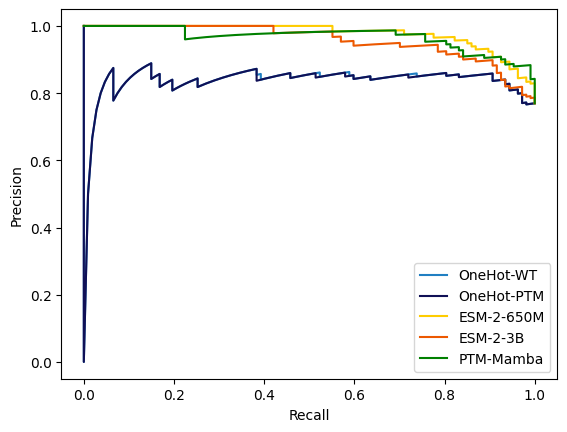

In [ ]:
plt.figure()
for model_name, (precision_curve, recall_curve, _, _) in drug_model_curves.items():
	color = color_map[model_name]
	plt.plot(recall_curve, precision_curve, label=model_name, color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

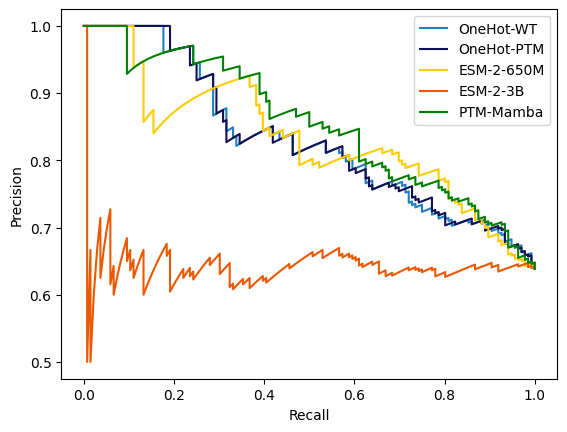

In [ ]:
plt.figure()
for model_name, (precision_curve, recall_curve, _, _) in disease_model_curves.items():
	color = color_map[model_name]
	plt.plot(recall_curve, precision_curve, label=model_name, color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

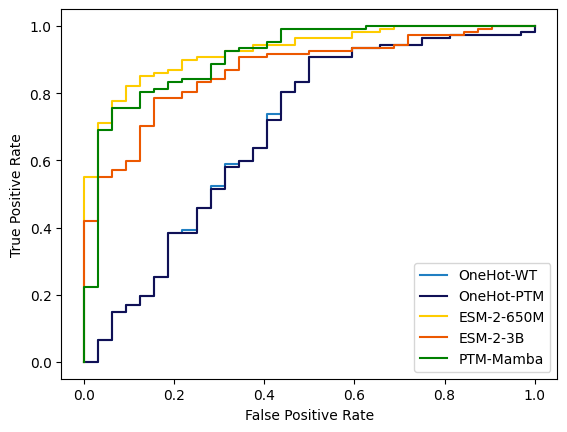

In [ ]:
plt.figure()
for model_name, (_, _, fpr, tpr) in drug_model_curves.items():
	color = color_map[model_name]
	plt.plot(fpr, tpr, label=model_name, color=color)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

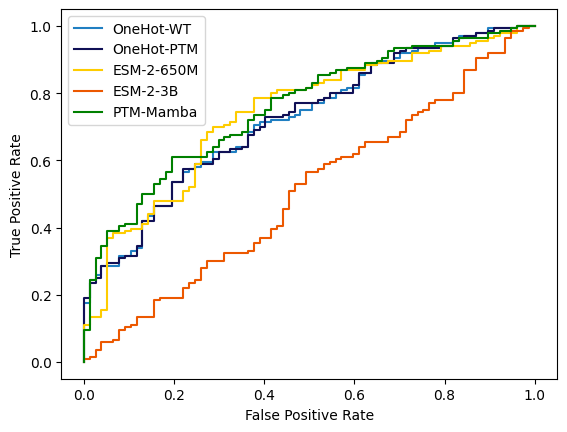

In [ ]:
plt.figure()
for model_name, (_, _, fpr, tpr) in disease_model_curves.items():
	color = color_map[model_name]
	plt.plot(fpr, tpr, label=model_name, color=color)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Transpose your DataFrame to group by metrics instead of models
# # The new DataFrame (transposed_df) will have metrics as its index and models as its columns
# transposed_df = disease_metrics_df.T  # Assuming 'disease_metrics_df' is your original DataFrame

# plt.figure(figsize=(10, 6))  # Increase figure size
# ax = plt.subplot(111)
# bar_width = 0.1  # Adjust bar width if necessary
# index = np.arange(len(transposed_df.index))  # Now index is based on metrics
# models = transposed_df.columns  # Columns are now the models

# for i, model in enumerate(models):
#     ax.bar(index + i * bar_width, transposed_df[model], bar_width, label=model)

# ax.set_xlabel('Metric', fontsize=12)
# ax.set_ylabel('Value', fontsize=12)
# ax.set_title('Disease Classification Metrics by Accuracy', fontsize=14)
# ax.set_xticks(index + bar_width / 2 * len(models))  # Centering the x-ticks
# ax.set_xticklabels(transposed_df.index, rotation=45, ha='right')  # Rotate labels to prevent overlap
# ax.legend(fontsize=10, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Transpose your DataFrame to group by metrics instead of models
# # The new DataFrame (transposed_df) will have metrics as its index and models as its columns
# transposed_df = drugptm_metrics_df.T  # Assuming 'disease_metrics_df' is your original DataFrame

# plt.figure(figsize=(10, 6))  # Increase figure size
# ax = plt.subplot(111)
# bar_width = 0.1  # Adjust bar width if necessary
# index = np.arange(len(transposed_df.index))  # Now index is based on metrics
# models = transposed_df.columns  # Columns are now the models

# for i, model in enumerate(models):
#     ax.bar(index + i * bar_width, transposed_df[model], bar_width, label=model)

# ax.set_xlabel('Metric', fontsize=12)
# ax.set_ylabel('Value', fontsize=12)
# ax.set_title('Druggability Classification Metrics by Accuracy', fontsize=14)
# ax.set_xticks(index + bar_width / 2 * len(models))  # Centering the x-ticks
# ax.set_xticklabels(transposed_df.index, rotation=45, ha='right')  # Rotate labels to prevent overlap
# ax.legend(fontsize=10, title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
# plt.show()
